## Initial data transformation and processing

In [35]:
import scipy.io as sio
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import utils as ut
reload(ut)
%matplotlib inline

In [2]:
data_array = sio.loadmat('data/DATASET.mat')['DATASET']

Original dataset has all variables as imaginary numbers, for most of them the imaginary part is zero. But for FFT variables imaginary part is non-zero.

We'll split variables with imaginary part in real and imaginary as separate variables. Then, all variables will be represented as floats.

In [3]:
# Get only real part
data_float = data_array.copy().real.astype(float)
# Get imaginary part
imaginary_L_FFT = data_array.imag[:, 597:797]
imaginary_R_FFT = data_array.imag[:, 797:997]
# Array with all variables as float (includding imaginary part as a separate variable)
all_float_array = np.hstack((data_float[:, :997], imaginary_L_FFT, imaginary_R_FFT, data_float[:, 997:]))

In [4]:
# Imaginary components are now separated
print 'original dataset shape:', data_array.shape
print 'all floats dataset shape:', all_float_array.shape

original dataset shape: (65600, 1039)
all floats dataset shape: (65600, 1439)


Now we will include feature names:

In [5]:
def define_column_names():
    column_names = []
    # Time series
    for i in range(200):
        column_names.append('L_HRIR_{:d}'.format(i))
    for i in range(200):
        column_names.append('R_HRIR_{:d}'.format(i))

    # Frequency Series
    for i in range(98):
        column_names.append('L_HRTF_{:d}'.format(i))
    for i in range(98):
        column_names.append('R_HRTF_{:d}'.format(i))

    # Complex Response
    for i in range(200):
        column_names.append('L_FFT_real_{:d}'.format(i))
    for i in range(200):
        column_names.append('R_HRIR_real_{:d}'.format(i))
    for i in range(200):
        column_names.append('L_FFT_imag_{:d}'.format(i))
    for i in range(200):
        column_names.append('R_HRIR_imag_{:d}'.format(i))
    # Interaction Parameters
    # Time-arrival Difference
    column_names.append('ITD')
    # Intensity Difference
    column_names.append('IID')
    # Spectral Difference
    column_names.append('DS')
    # Head Parameters
    column_names.append('head_width')
    column_names.append('head_height')
    column_names.append('head_depth')
    column_names.append('pinna_offset_down')
    column_names.append('pinna_offset_back')
    column_names.append('neck_width')
    column_names.append('neck_height')
    column_names.append('neck_depth')
    column_names.append('torso_top_width')
    column_names.append('torso_top_heigth')
    column_names.append('torso_top_depth')
    column_names.append('shoulder_width')
    column_names.append('head_offset_forward')
    column_names.append('height')
    column_names.append('seated_height')
    column_names.append('head_circumference ')
    column_names.append('shoulder_circumference')

    # Ear Parameters
    column_names.append('L_cavum_concha_heigth')
    column_names.append('L_cymba_concha_heigth')
    column_names.append('L_cavum_concha_width')
    column_names.append('L_fossa_height')
    column_names.append('L_pinna_height')
    column_names.append('L_pinna_width')
    column_names.append('L_intertragal_incisure_width')
    column_names.append('L_cavum_concha_depth')
    column_names.append('R_cavum_concha_heigth')
    column_names.append('R_cymba_concha_heigth')
    column_names.append('R_cavum_concha_width')
    column_names.append('R_fossa_height')
    column_names.append('R_pinna_height')
    column_names.append('R_pinna_width')
    column_names.append('R_intertragaR_incisure_width')
    column_names.append('R_cavum_concha_depth')

    # Pinnae Rotation Parameters
    column_names.append('L_pinna_rotation_angle')
    column_names.append('L_pinna_flare_angle')
    column_names.append('R_pinna_rotation_angle')
    column_names.append('R_pinna_flare_angle')

    # Target
    column_names.append('azimuth')
    column_names.append('elevation')

    # Subject Id
    column_names.append('subject_id')
    return column_names

In [6]:
column_names = define_column_names()

In [7]:
# Build Pandas DataFrame
df = pd.DataFrame(all_float_array, columns=column_names)

In [8]:
# col_ix Dictionary can be used to get the index of any feature
col_ix = {}
for i, col in enumerate(df.columns):
    col_ix[col] = i

In [9]:
# Should match the number of colums in dataset
len(column_names)

1439

### Number of unique azimuth, elevation and subject_id values

In [10]:
print 'azimuth: \nunique', df.azimuth.nunique(), '\n', df.azimuth.describe().transpose()
print 'elevation: \n unique', df.elevation.nunique(), df.elevation.describe().transpose()
print 'subject_id:', df.subject_id.nunique()

azimuth: 
unique 60 
count    65600.000000
mean        -4.321646
std        107.656501
min       -180.000000
25%       -100.000000
50%         -0.000000
75%         80.000000
max        175.000000
Name: azimuth, dtype: float64
elevation: 
 unique 32 count    65600.000000
mean        17.841797
std         40.146042
min        -50.625000
25%        -16.875000
50%         16.875000
75%         50.625000
max         90.000000
Name: elevation, dtype: float64
subject_id: 95


Full dataset contains data from two original datasets.

For the moment we will work with the first dataset only.

In [11]:
ds_1 = df.ix[:56249].copy()
ds_1.shape

(56250, 1439)

In [12]:
# TOTAL Unique Subjects for dataset 1 = 45
ds_1.loc[:, ('subject_id')] = ds_1['subject_id'].astype(int)
ds_1.subject_id.unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45])

## Inter-subject variation for same azimuth and elevation angles

In [13]:
df.elevation.unique()

array([-45.   , -39.375, -33.75 , -28.125, -22.5  , -16.875, -11.25 ,
        -5.625,   0.   ,   5.625,  11.25 ,  16.875,  22.5  ,  28.125,
        33.75 ,  39.375,  45.   ,  50.625,  56.25 ,  61.875,  67.5  ,
        73.125,  78.75 ,  84.375,  90.   , -50.625, -30.   , -15.   ,
        15.   ,  30.   ,  60.   ,  75.   ])

In [14]:
498 + 98

596

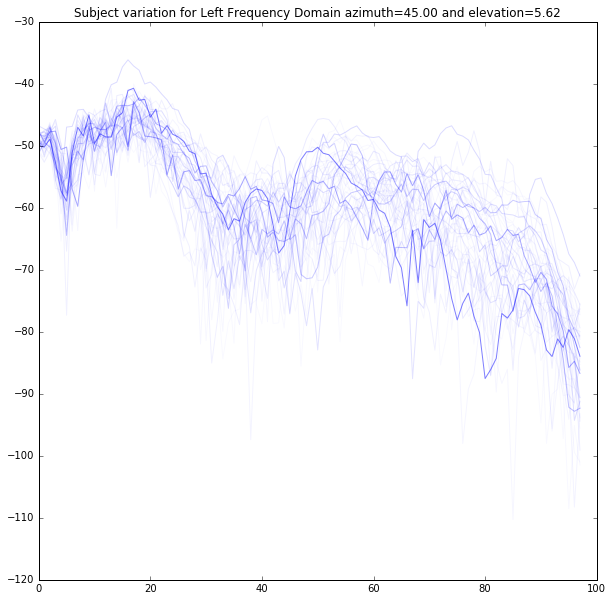

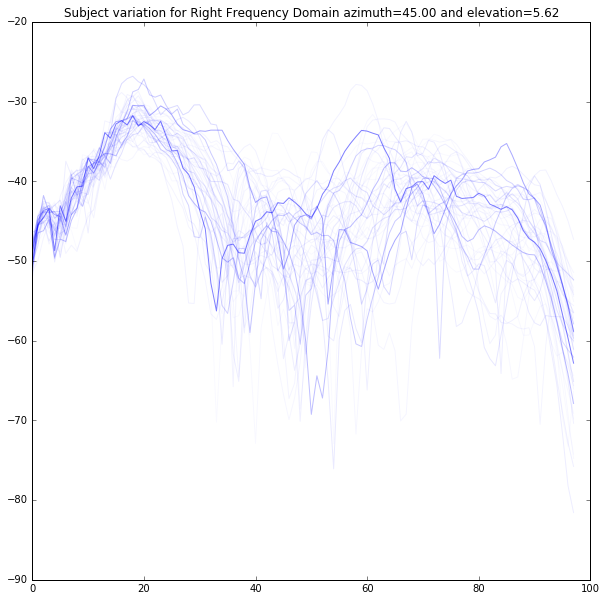

In [15]:
#azimuth = np.random.randint(-180, 175)
#elevation = np.random.randint(-50, 90)
azimuth, elevation = 45.0, 5.625
location = ds_1[(ds_1.azimuth == azimuth) & (ds_1.elevation == elevation)]
l_range = range(400, 498)
r_range = range(498, 596)
l_hrtf = location.iloc[:,l_range]
r_hrtf = location.iloc[:, r_range]
j = 1
plt.figure(figsize=(10, 10))
for i in range(1, 45):
    first = l_hrtf[location.subject_id == i].iloc[0]
    plt.plot(range(len(l_range)), first, c='b', alpha=1.0/(j+1))
    j += 1
plt.title('Subject variation for Left Frequency Domain azimuth={:.2f} and elevation={:.2f}'.format(azimuth, elevation))
plt.show()

j = 1
plt.figure(figsize=(10, 10))
for i in range(1, 45):
    first = r_hrtf[location.subject_id == i].iloc[0]
    plt.plot(range(len(r_range)), first, c='b', alpha=1.0/(j+1))
    j += 1
#plt.legend(loc='upper right')
plt.title('Subject variation for Right Frequency Domain azimuth={:.2f} and elevation={:.2f}'.format(azimuth, elevation))
plt.show()

By Analayzing non-HRTF features (measurements of subjects) we discover that dome of them are missing, so we decide to substitute missing values with the mean of each feature.

In [16]:
ds_1.ix[:, 1399:].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
head_width,46250.0,14.428826,0.905161,12.646597,13.903307,14.443268,14.892092,16.203902
head_height,46250.0,21.377795,1.161957,18.865526,20.665188,21.311794,22.090244,23.842658
head_depth,46250.0,19.900724,1.312059,16.660570,19.275830,19.915320,20.870571,23.064239
pinna_offset_down,46250.0,3.006494,0.586056,1.408322,2.446867,3.220209,3.469709,3.772236
pinna_offset_back,46250.0,0.389666,0.590552,-1.170696,0.167971,0.393765,0.785692,1.899457
neck_width,46250.0,11.518612,0.997720,9.408768,11.020129,11.549176,12.212968,14.042607
neck_height,46250.0,6.177656,1.972471,1.905978,4.982187,6.340924,7.461400,10.600237
neck_depth,46250.0,10.477648,1.134602,7.837414,9.936521,10.372081,11.325472,12.534256
torso_top_width,46250.0,30.953683,2.606181,25.202642,29.566625,31.213773,32.422859,36.839476
torso_top_heigth,46250.0,13.429684,1.939632,9.412423,12.236193,13.005980,14.494436,17.560892


## Baseline Models for Azimuth and Elevation
### Dataset split
- training: 75%
- validation: 10%
- test: 15%

In [17]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, export_graphviz
from sklearn.metrics import mean_absolute_error
from math import ceil

In [18]:
def split_dataset(n, training_perc=0.75, val_perc=0.1):
    train_size = int(ceil(n*training_perc))
    val_size = int(ceil(n*val_perc))
    shuffled_ix = np.random.choice(range(1, n+1), n, replace=False)
    return shuffled_ix[:train_size], shuffled_ix[train_size:train_size + val_size], shuffled_ix[train_size + val_size:]

In [19]:
# Fit regression model
# Only use this columns for the moment
cols_range = range(0, 1399) + range(-3, 0, 1)
ds_1 = ds_1.ix[:, cols_range]
n = 45

In [20]:
#train_ix, val_ix, test_ix = split_dataset(n)
#train_ix.sort()
#val_ix.sort()
#test_ix.sort()
#print 'chosen training subjects:', train_ix
#print 'chosen validation subjects:', val_ix
#print 'chosen test subjects:', test_ix

From now on, chosen users will be used for each dataset (trainig, validation and testing)

In [21]:
def get_splitted_dataset(ds):
    train_ix = [2, 3, 4, 5, 6, 8, 9, 10, 11, 13, 14, 15, 16, 17, 18, 19, 22, 23,
                25, 26, 27, 28, 31, 33, 34, 35, 36, 37, 39, 40, 41, 42, 43, 44]
    val_ix = [7, 24, 29, 30, 38]
    test_ix = [1, 12, 20, 21, 32, 45]

    train = ds[ds.subject_id.isin(train_ix)]
    val = ds[ds.subject_id.isin(val_ix)]
    test = ds[ds.subject_id.isin(test_ix)]
    return train, val, test

In [22]:
train, val, test = get_splitted_dataset(ds_1)

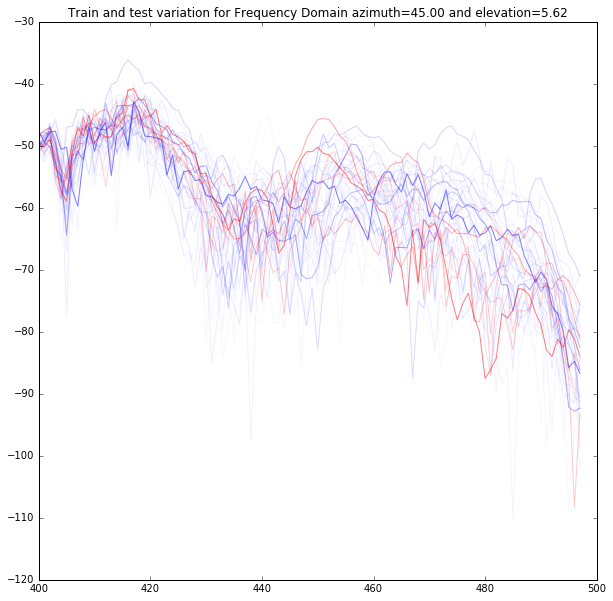

In [23]:
plt.figure(figsize=(10, 10))
#azimuth = np.random.randint(-180, 175)
#elevation = np.random.randint(-50, 90)
azimuth, elevation = 45.0, 5.625
range_ = range(400, 498)
train_location = train[((train.azimuth == azimuth) & (train.elevation == elevation))]
test_location = test[((test.azimuth == azimuth) & (test.elevation == elevation))]
l_hrtf = train_location.ix[:, range_]
l_hrtf_test = test_location.ix[:, range_]
j = 1
for i in train.subject_id.unique():
    subj_train = l_hrtf[train_location.subject_id == i].iloc[0]
    plt.plot(range_, subj_train, c='b', alpha=1.0/(j+1))
    j += 1
j = 1
for i in test.subject_id.unique():
    subj_test = l_hrtf_test[test_location.subject_id == i].iloc[0]
    plt.plot(range_, subj_test, c='r', alpha=1.0/(j+1))
    j += 1
plt.title('Train and test variation for Frequency Domain azimuth={:.2f} and elevation={:.2f}'.format(azimuth, elevation))
plt.show()

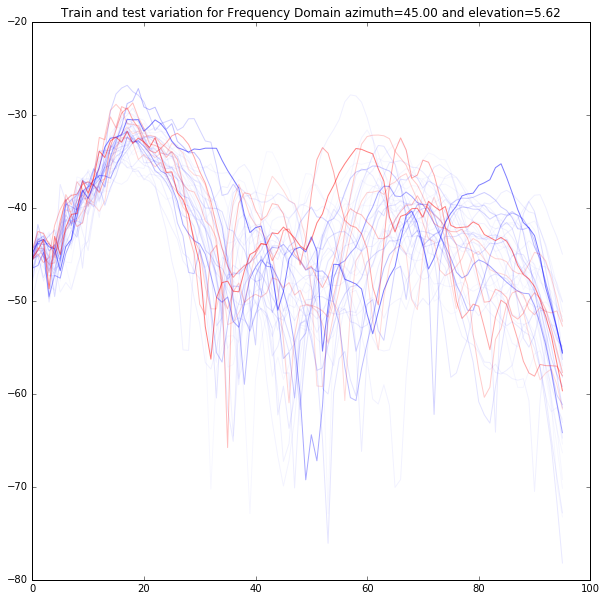

In [24]:
plt.figure(figsize=(10, 10))
#azimuth = np.random.randint(-180, 175)
#elevation = np.random.randint(-50, 90)
azimuth, elevation = 45.0, 5.625
#range_ = range(400, 498)
range_ = range(499, 595)
train_location = train[((train.azimuth == azimuth) & (train.elevation == elevation))]
test_location = test[((test.azimuth == azimuth) & (test.elevation == elevation))]
l_hrtf = train_location.ix[:, range_]
l_hrtf_test = test_location.ix[:, range_]
j = 1
for i in train.subject_id.unique():
    subj_train = l_hrtf[train_location.subject_id == i].iloc[0]
    plt.plot(range(len(range_)), subj_train, c='b', alpha=1.0/(j+1))
    j += 1
j = 1
for i in test.subject_id.unique():
    subj_test = l_hrtf_test[test_location.subject_id == i].iloc[0]
    plt.plot(range(len(range_)), subj_test, c='r', alpha=1.0/(j+1))
    j += 1
plt.title('Train and test variation for Frequency Domain azimuth={:.2f} and elevation={:.2f}'.format(azimuth, elevation))
plt.show()

### Building baseline models for Elevation

In [36]:
X_train, y_train, X_val, y_val, X_test, y_test = ut.separate_target(train, val, test, target='elevation')
print X_train.shape, y_train.shape
print X_test.shape, y_test.shape

(42500, 1399) (42500,)
(7500, 1399) (7500,)


In [37]:
# Regression Tree Baseline Model
# command: dot -Tpng tree4.dot -o tree4.png
depth = 10
regr = DecisionTreeRegressor(max_depth=depth)
regr.fit(X_train, y_train)

DecisionTreeRegressor(criterion='mse', max_depth=10, max_features=None,
           max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=None,
           splitter='best')

In [43]:
# Predict on training data
y_pred_train = regr.predict(X_train)
loss_train = mean_absolute_error(y_train, y_pred_train)
# Predict on test data
y_pred = regr.predict(X_test)
loss = mean_absolute_error(y_test, y_pred)
y_pred_val = regr.predict(X_val)
loss_val = mean_absolute_error(y_val, y_pred_val)
print 'train', loss_train
print 'validation', loss_val
print 'test', loss

train 10.1815343398
validation 16.6380817693
test 15.0576808408


In [39]:
# Number of possible outcomes in built tree, comparte to 32 unique values of elevation
pd.Series(y_pred).nunique()

441

In [40]:
# Classification Tree Baseline Model
# command: dot -Tpng tree4.dot -o tree4.png
depth=10
c_tree = DecisionTreeClassifier(max_depth=depth)
c_tree.fit(X_train, y_train.astype(np.str))

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=10,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

In [44]:
# Predict on training data
y_pred_train = c_tree.predict(X_train)
loss_train = mean_absolute_error(y_train, y_pred_train)
# Predict on test data
y_pred = c_tree.predict(X_test)
loss = mean_absolute_error(y_test, y_pred)
y_pred_val = c_tree.predict(X_val)
loss_val = mean_absolute_error(y_val, y_pred_val)
print 'train', loss_train
print 'validation', loss_val
print 'test', loss

train 13.6250735294
validation 18.7704
test 16.557


### Building baseline models for Azimuth

In [45]:
X_train, y_train, X_val, y_val, X_test, y_test = ut.separate_target(train, val, test, target='azimuth')
print X_train.shape, y_train.shape
print X_test.shape, y_test.shape

(42500, 1399) (42500,)
(7500, 1399) (7500,)


In [46]:
# Regression Tree Baseline Model
# command: dot -Tpng tree4.dot -o tree4.png
depth = 10
regr = DecisionTreeRegressor(max_depth=depth)
regr.fit(X_train, y_train)

DecisionTreeRegressor(criterion='mse', max_depth=10, max_features=None,
           max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=None,
           splitter='best')

In [ ]:
# Predict on training data
y_pred_train = regr.predict(X_train)
loss_train = mean_absolute_error(y_train, y_pred_train)
# Predict on test data
y_pred = regr.predict(X_test)
loss = ut.loss_azimuth(y_test, y_pred)
y_pred_val = regr.predict(X_val)
loss_val = ut.loss_azimuth(y_val, y_pred_val)
print 'train', loss_train
print 'validation', loss_val
print 'test', loss

In [ ]:
# Number of possible outcomes in built tree, comparte to 32 unique values of elevation
pd.Series(y_pred).nunique()

In [ ]:
# Classification Tree Baseline Model
# command: dot -Tpng tree4.dot -o tree4.png
depth=10
c_tree = DecisionTreeClassifier(max_depth=depth)
c_tree.fit(X_train, y_train.astype(np.str))

In [ ]:
# Predict on training data
y_pred_train = c_tree.predict(X_train)
loss_train = mean_absolute_error(y_train, y_pred_train)
# Predict on test data
y_pred = c_tree.predict(X_test)
loss = mean_absolute_error(y_test, y_pred)

print 'train', loss_train
print 'test', loss

## Include all features

In [ ]:
# Include all features
ds_2 = df.ix[:56249].copy()
n = 45

# Substitute missing values with feature mean
means = ds_2.mean(axis=0)
ds_2 = ds_2.fillna(means)

In [ ]:
ds_2.ix[:, 1400:].corr()

In [ ]:
train, val, test = get_splitted_dataset(ds_2)

In [ ]:
# Write .csv for each set
#train.to_csv('data/ds2_train.csv')
#val.to_csv('data/ds2_val.csv')
#test.to_csv('data/ds2_test.csv')

In [ ]:
print train.shape, val.shape, test.shape

## Include some additional features
We decided to incorporate some additional statistics for teh series data (min, max, mean values) these could help in cases where subject variation distrurbs the series.

In [ ]:
# Include all features
ds = ds_2.copy()
ds_3 = ds_2.copy()
n = 45

sides = ['L', 'R']
features = ['HRIR', 'HRTF']
features_length = [200, 98]

ds_3.drop('elevation', axis=1, inplace=True)
ds_3.drop('azimuth', axis=1, inplace=True)
ds_3.drop('subject_id', axis=1, inplace=True)

for i, feature in enumerate(features):
    for side in sides:
        feature_name = side + '_' + feature
        feature_name_first = feature_name + '_0'
        range_feature = range(col_ix[feature_name_first], col_ix[feature_name_first] + features_length[i])
        min_summ = ds_3.ix[:, range_feature].min(axis=1)
        max_summ = ds_3.ix[:, range_feature].max(axis=1)
        mean_summ = ds_3.ix[:, range_feature].mean(axis=1)
        ds_3[feature_name + '_min'] = min_summ
        ds_3[feature_name + '_max'] = max_summ
        ds_3[feature_name + '_mean'] = mean_summ
        
ds_3['elevation'] = ds['elevation']
ds_3['azimuth'] = ds['azimuth']
ds_3['subject_id'] = ds['subject_id']

ds_3.ix[:, -15:].corr()

We identified high correlation values with azimuth, so this should help us improve our baseline model in this prediction task.

In [ ]:
train, val, test = get_splitted_dataset(ds_3)

In [ ]:
# Write .csv for each set
#train.to_csv('data/ds3_train.csv')
#val.to_csv('data/ds3_val.csv')
#test.to_csv('data/ds3_test.csv')

In [ ]:
# Regression Tree Baseline Model
# command: dot -Tpng tree4.dot -o tree4.png
depth = 10
regr = DecisionTreeRegressor(max_depth=depth)
regr.fit(X_train, y_train)

In [ ]:
# Predict on training data
y_pred_train = regr.predict(X_train)
loss_train = mean_absolute_error(y_train, y_pred_train)
# Predict on test data
y_pred = regr.predict(X_test)
loss = mean_absolute_error(y_test, y_pred)

y_pred_val = regr.predict(X_val)
loss_val = mean_absolute_error(y_val, y_pred_val)

print 'train', loss_train
print 'validation', loss_val
print 'test', loss

In [ ]:
# Classification Tree Baseline Model
# command: dot -Tpng tree4.dot -o tree4.png
depth=8
c_tree = DecisionTreeClassifier(max_depth=depth)
c_tree.fit(X_train, y_train.astype(np.str))

with open('class_tree' + str(depth) + '.dot', 'w') as dotfile:
    export_graphviz(
        regr,
        dotfile,
        feature_names=X_train.columns)

# Predict
y_pred = c_tree.predict(X_test).astype(np.float64)
loss = mean_absolute_error(y_test, y_pred)

print loss

In [ ]:
importances = pd.Series(regr.feature_importances_, index=ds_3.columns[:-3])

In [ ]:
# More informative features
importances.sort_values(ascending=False, inplace=True)
importances[:30].plot(kind='bar', figsize=(10,5))

In [ ]:
# Less informative features
importances.sort_values(ascending=True, inplace=True)
importances[:40]

In [ ]:
importances[ds.columns[1400:-3]].plot(kind='bar', figsize=(10,5))